In [1]:
import os
import glob
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from PIL import Image
import timm
from torchvision import transforms
from tqdm.auto import tqdm 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

In [2]:
# --- 2. CONFIGURATION ---
DATA_ROOT = '/kaggle/input/leukemia/Original' 
CLASSES = ['Benign', 'Early', 'Pre', 'Pro']
BATCH_SIZE = 16
NUM_FOLDS = 5
EPOCHS = 15
LR = 1e-4
IMG_SIZE = 224
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"Device: {DEVICE}")

Device: cuda


In [3]:
# --- 3. DATA PREPARATION ---
print("--- Loading File Paths ---")
all_paths = []
all_labels = []

class_to_idx = {cls_name: i for i, cls_name in enumerate(CLASSES)}

for cls_name in CLASSES:
    cls_folder = os.path.join(DATA_ROOT, cls_name)
    files = glob.glob(os.path.join(cls_folder, '*'))
    for f in files:
        all_paths.append(f)
        all_labels.append(class_to_idx[cls_name])

print(f"Total Images: {len(all_paths)}")

--- Loading File Paths ---
Total Images: 3256


In [4]:
# --- 4. DATASET CLASS ---
class CachedDataset(Dataset):
    def __init__(self, file_paths, labels, img_size):
        self.data = []
        self.labels = labels
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        print(f"Caching images to RAM... (Speeds up training)")
        for img_path in tqdm(file_paths, desc="Loading"):
            with Image.open(img_path) as img:
                self.data.append(transforms.Resize((img_size, img_size))(img.convert('RGB')))

    def __len__(self): return len(self.data)
    def __getitem__(self, idx): return self.transform(self.data[idx]), torch.tensor(self.labels[idx], dtype=torch.long)

In [5]:
# Initialize Dataset
dataset = CachedDataset(all_paths, all_labels, IMG_SIZE)

Caching images to RAM... (Speeds up training)


Loading:   0%|          | 0/3256 [00:00<?, ?it/s]

In [6]:
# --- 5. TRAINING FUNCTION (PER FOLD) ---
def train_fold(fold_index, train_idx, val_idx):
    print(f"\n{'='*15} Starting Fold {fold_index+1}/{NUM_FOLDS} {'='*15}")
    
    train_loader = DataLoader(Subset(dataset, train_idx), batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
    val_loader = DataLoader(Subset(dataset, val_idx), batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
    
    model = timm.create_model('swin_tiny_patch4_window7_224', pretrained=False, num_classes=4).to(DEVICE)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=LR)
    
    # --- HISTORY TRACKING (This is what enables the curves) ---
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
    
    best_acc = 0.0
    val_preds = []
    val_targets = []
    
    for epoch in range(EPOCHS):
        model.train()
        correct, total = 0, 0
        r_loss = 0.0
        
        loop = tqdm(train_loader, desc=f"Ep {epoch+1}", leave=False)
        for inputs, targets in loop:
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            
            r_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            loop.set_postfix(acc=100.*correct/total)
            
        # Validation
        model.eval()
        v_correct, v_total = 0, 0
        v_loss_accum = 0.0
        curr_preds, curr_targets = [], []
        
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                v_loss_accum += loss.item()
                
                _, predicted = outputs.max(1)
                v_total += targets.size(0)
                v_correct += predicted.eq(targets).sum().item()
                
                curr_preds.extend(predicted.cpu().numpy())
                curr_targets.extend(targets.cpu().numpy())
        
        # Calculate Epoch Metrics
        t_loss = r_loss / len(train_loader)
        v_loss = v_loss_accum / len(val_loader)
        t_acc = 100.*correct/total
        v_acc = 100.*v_correct/v_total
        
        # Save to History
        history['train_loss'].append(t_loss)
        history['val_loss'].append(v_loss)
        history['train_acc'].append(t_acc)
        history['val_acc'].append(v_acc)
        
        if v_acc > best_acc:
            best_acc = v_acc
            val_preds = curr_preds
            val_targets = curr_targets
            
        print(f"  Ep {epoch+1} | Val Acc: {v_acc:.2f}%")
        
    return history, val_preds, val_targets

In [7]:
# --- 6. EXECUTION LOOP ---
kfold = KFold(n_splits=NUM_FOLDS, shuffle=True, random_state=42)
all_results = [] 

# Run the 5 Folds
for i, (t_idx, v_idx) in enumerate(kfold.split(dataset)):
    hist, preds, targets = train_fold(i, t_idx, v_idx)
    all_results.append((hist, preds, targets))


=============== Starting Fold 1/5 ===============


Ep 1:   0%|          | 0/163 [00:00<?, ?it/s]

  Ep 1 | Val Acc: 74.39%


Ep 2:   0%|          | 0/163 [00:00<?, ?it/s]

  Ep 2 | Val Acc: 72.39%


Ep 3:   0%|          | 0/163 [00:00<?, ?it/s]

  Ep 3 | Val Acc: 79.60%


Ep 4:   0%|          | 0/163 [00:00<?, ?it/s]

  Ep 4 | Val Acc: 80.98%


Ep 5:   0%|          | 0/163 [00:00<?, ?it/s]

  Ep 5 | Val Acc: 87.88%


Ep 6:   0%|          | 0/163 [00:00<?, ?it/s]

  Ep 6 | Val Acc: 85.28%


Ep 7:   0%|          | 0/163 [00:00<?, ?it/s]

  Ep 7 | Val Acc: 86.96%


Ep 8:   0%|          | 0/163 [00:00<?, ?it/s]

  Ep 8 | Val Acc: 89.57%


Ep 9:   0%|          | 0/163 [00:00<?, ?it/s]

  Ep 9 | Val Acc: 92.79%


Ep 10:   0%|          | 0/163 [00:00<?, ?it/s]

  Ep 10 | Val Acc: 95.40%


Ep 11:   0%|          | 0/163 [00:00<?, ?it/s]

  Ep 11 | Val Acc: 95.40%


Ep 12:   0%|          | 0/163 [00:00<?, ?it/s]

  Ep 12 | Val Acc: 93.56%


Ep 13:   0%|          | 0/163 [00:00<?, ?it/s]

  Ep 13 | Val Acc: 90.64%


Ep 14:   0%|          | 0/163 [00:00<?, ?it/s]

  Ep 14 | Val Acc: 96.01%


Ep 15:   0%|          | 0/163 [00:00<?, ?it/s]

  Ep 15 | Val Acc: 94.17%

=============== Starting Fold 2/5 ===============


Ep 1:   0%|          | 0/163 [00:00<?, ?it/s]

  Ep 1 | Val Acc: 78.03%


Ep 2:   0%|          | 0/163 [00:00<?, ?it/s]

  Ep 2 | Val Acc: 77.27%


Ep 3:   0%|          | 0/163 [00:00<?, ?it/s]

  Ep 3 | Val Acc: 76.80%


Ep 4:   0%|          | 0/163 [00:00<?, ?it/s]

  Ep 4 | Val Acc: 85.25%


Ep 5:   0%|          | 0/163 [00:00<?, ?it/s]

  Ep 5 | Val Acc: 89.25%


Ep 6:   0%|          | 0/163 [00:00<?, ?it/s]

  Ep 6 | Val Acc: 89.86%


Ep 7:   0%|          | 0/163 [00:00<?, ?it/s]

  Ep 7 | Val Acc: 92.47%


Ep 8:   0%|          | 0/163 [00:00<?, ?it/s]

  Ep 8 | Val Acc: 90.17%


Ep 9:   0%|          | 0/163 [00:00<?, ?it/s]

  Ep 9 | Val Acc: 87.86%


Ep 10:   0%|          | 0/163 [00:00<?, ?it/s]

  Ep 10 | Val Acc: 94.62%


Ep 11:   0%|          | 0/163 [00:00<?, ?it/s]

  Ep 11 | Val Acc: 90.63%


Ep 12:   0%|          | 0/163 [00:00<?, ?it/s]

  Ep 12 | Val Acc: 93.09%


Ep 13:   0%|          | 0/163 [00:00<?, ?it/s]

  Ep 13 | Val Acc: 95.39%


Ep 14:   0%|          | 0/163 [00:00<?, ?it/s]

  Ep 14 | Val Acc: 96.01%


Ep 15:   0%|          | 0/163 [00:00<?, ?it/s]

  Ep 15 | Val Acc: 95.39%

=============== Starting Fold 3/5 ===============


Ep 1:   0%|          | 0/163 [00:00<?, ?it/s]

  Ep 1 | Val Acc: 76.80%


Ep 2:   0%|          | 0/163 [00:00<?, ?it/s]

  Ep 2 | Val Acc: 74.35%


Ep 3:   0%|          | 0/163 [00:00<?, ?it/s]

  Ep 3 | Val Acc: 82.18%


Ep 4:   0%|          | 0/163 [00:00<?, ?it/s]

  Ep 4 | Val Acc: 81.87%


Ep 5:   0%|          | 0/163 [00:00<?, ?it/s]

  Ep 5 | Val Acc: 85.41%


Ep 6:   0%|          | 0/163 [00:00<?, ?it/s]

  Ep 6 | Val Acc: 88.33%


Ep 7:   0%|          | 0/163 [00:00<?, ?it/s]

  Ep 7 | Val Acc: 91.24%


Ep 8:   0%|          | 0/163 [00:00<?, ?it/s]

  Ep 8 | Val Acc: 87.56%


Ep 9:   0%|          | 0/163 [00:00<?, ?it/s]

  Ep 9 | Val Acc: 93.39%


Ep 10:   0%|          | 0/163 [00:00<?, ?it/s]

  Ep 10 | Val Acc: 94.47%


Ep 11:   0%|          | 0/163 [00:00<?, ?it/s]

  Ep 11 | Val Acc: 95.08%


Ep 12:   0%|          | 0/163 [00:00<?, ?it/s]

  Ep 12 | Val Acc: 94.47%


Ep 13:   0%|          | 0/163 [00:00<?, ?it/s]

  Ep 13 | Val Acc: 93.39%


Ep 14:   0%|          | 0/163 [00:00<?, ?it/s]

  Ep 14 | Val Acc: 95.39%


Ep 15:   0%|          | 0/163 [00:00<?, ?it/s]

  Ep 15 | Val Acc: 96.31%

=============== Starting Fold 4/5 ===============


Ep 1:   0%|          | 0/163 [00:00<?, ?it/s]

  Ep 1 | Val Acc: 74.96%


Ep 2:   0%|          | 0/163 [00:00<?, ?it/s]

  Ep 2 | Val Acc: 74.50%


Ep 3:   0%|          | 0/163 [00:00<?, ?it/s]

  Ep 3 | Val Acc: 82.18%


Ep 4:   0%|          | 0/163 [00:00<?, ?it/s]

  Ep 4 | Val Acc: 81.41%


Ep 5:   0%|          | 0/163 [00:00<?, ?it/s]

  Ep 5 | Val Acc: 80.18%


Ep 6:   0%|          | 0/163 [00:00<?, ?it/s]

  Ep 6 | Val Acc: 87.86%


Ep 7:   0%|          | 0/163 [00:00<?, ?it/s]

  Ep 7 | Val Acc: 90.02%


Ep 8:   0%|          | 0/163 [00:00<?, ?it/s]

  Ep 8 | Val Acc: 87.86%


Ep 9:   0%|          | 0/163 [00:00<?, ?it/s]

  Ep 9 | Val Acc: 92.32%


Ep 10:   0%|          | 0/163 [00:00<?, ?it/s]

  Ep 10 | Val Acc: 88.94%


Ep 11:   0%|          | 0/163 [00:00<?, ?it/s]

  Ep 11 | Val Acc: 95.08%


Ep 12:   0%|          | 0/163 [00:00<?, ?it/s]

  Ep 12 | Val Acc: 89.09%


Ep 13:   0%|          | 0/163 [00:00<?, ?it/s]

  Ep 13 | Val Acc: 94.01%


Ep 14:   0%|          | 0/163 [00:00<?, ?it/s]

  Ep 14 | Val Acc: 94.78%


Ep 15:   0%|          | 0/163 [00:00<?, ?it/s]

  Ep 3 | Val Acc: 80.65%


Ep 4:   0%|          | 0/163 [00:00<?, ?it/s]

  Ep 4 | Val Acc: 88.63%


Ep 5:   0%|          | 0/163 [00:00<?, ?it/s]

  Ep 5 | Val Acc: 90.17%


Ep 6:   0%|          | 0/163 [00:00<?, ?it/s]

  Ep 6 | Val Acc: 92.63%


Ep 7:   0%|          | 0/163 [00:00<?, ?it/s]

  Ep 7 | Val Acc: 92.63%


Ep 8:   0%|          | 0/163 [00:00<?, ?it/s]

  Ep 8 | Val Acc: 94.16%


Ep 9:   0%|          | 0/163 [00:00<?, ?it/s]

  Ep 9 | Val Acc: 94.32%


Ep 10:   0%|          | 0/163 [00:00<?, ?it/s]

  Ep 10 | Val Acc: 95.85%


Ep 11:   0%|          | 0/163 [00:00<?, ?it/s]

  Ep 11 | Val Acc: 90.63%


Ep 12:   0%|          | 0/163 [00:00<?, ?it/s]

  Ep 12 | Val Acc: 97.24%


Ep 13:   0%|          | 0/163 [00:00<?, ?it/s]

  Ep 13 | Val Acc: 96.62%


Ep 14:   0%|          | 0/163 [00:00<?, ?it/s]

  Ep 14 | Val Acc: 96.16%


Ep 15:   0%|          | 0/163 [00:00<?, ?it/s]

  Ep 15 | Val Acc: 95.85%



Generating Plots...


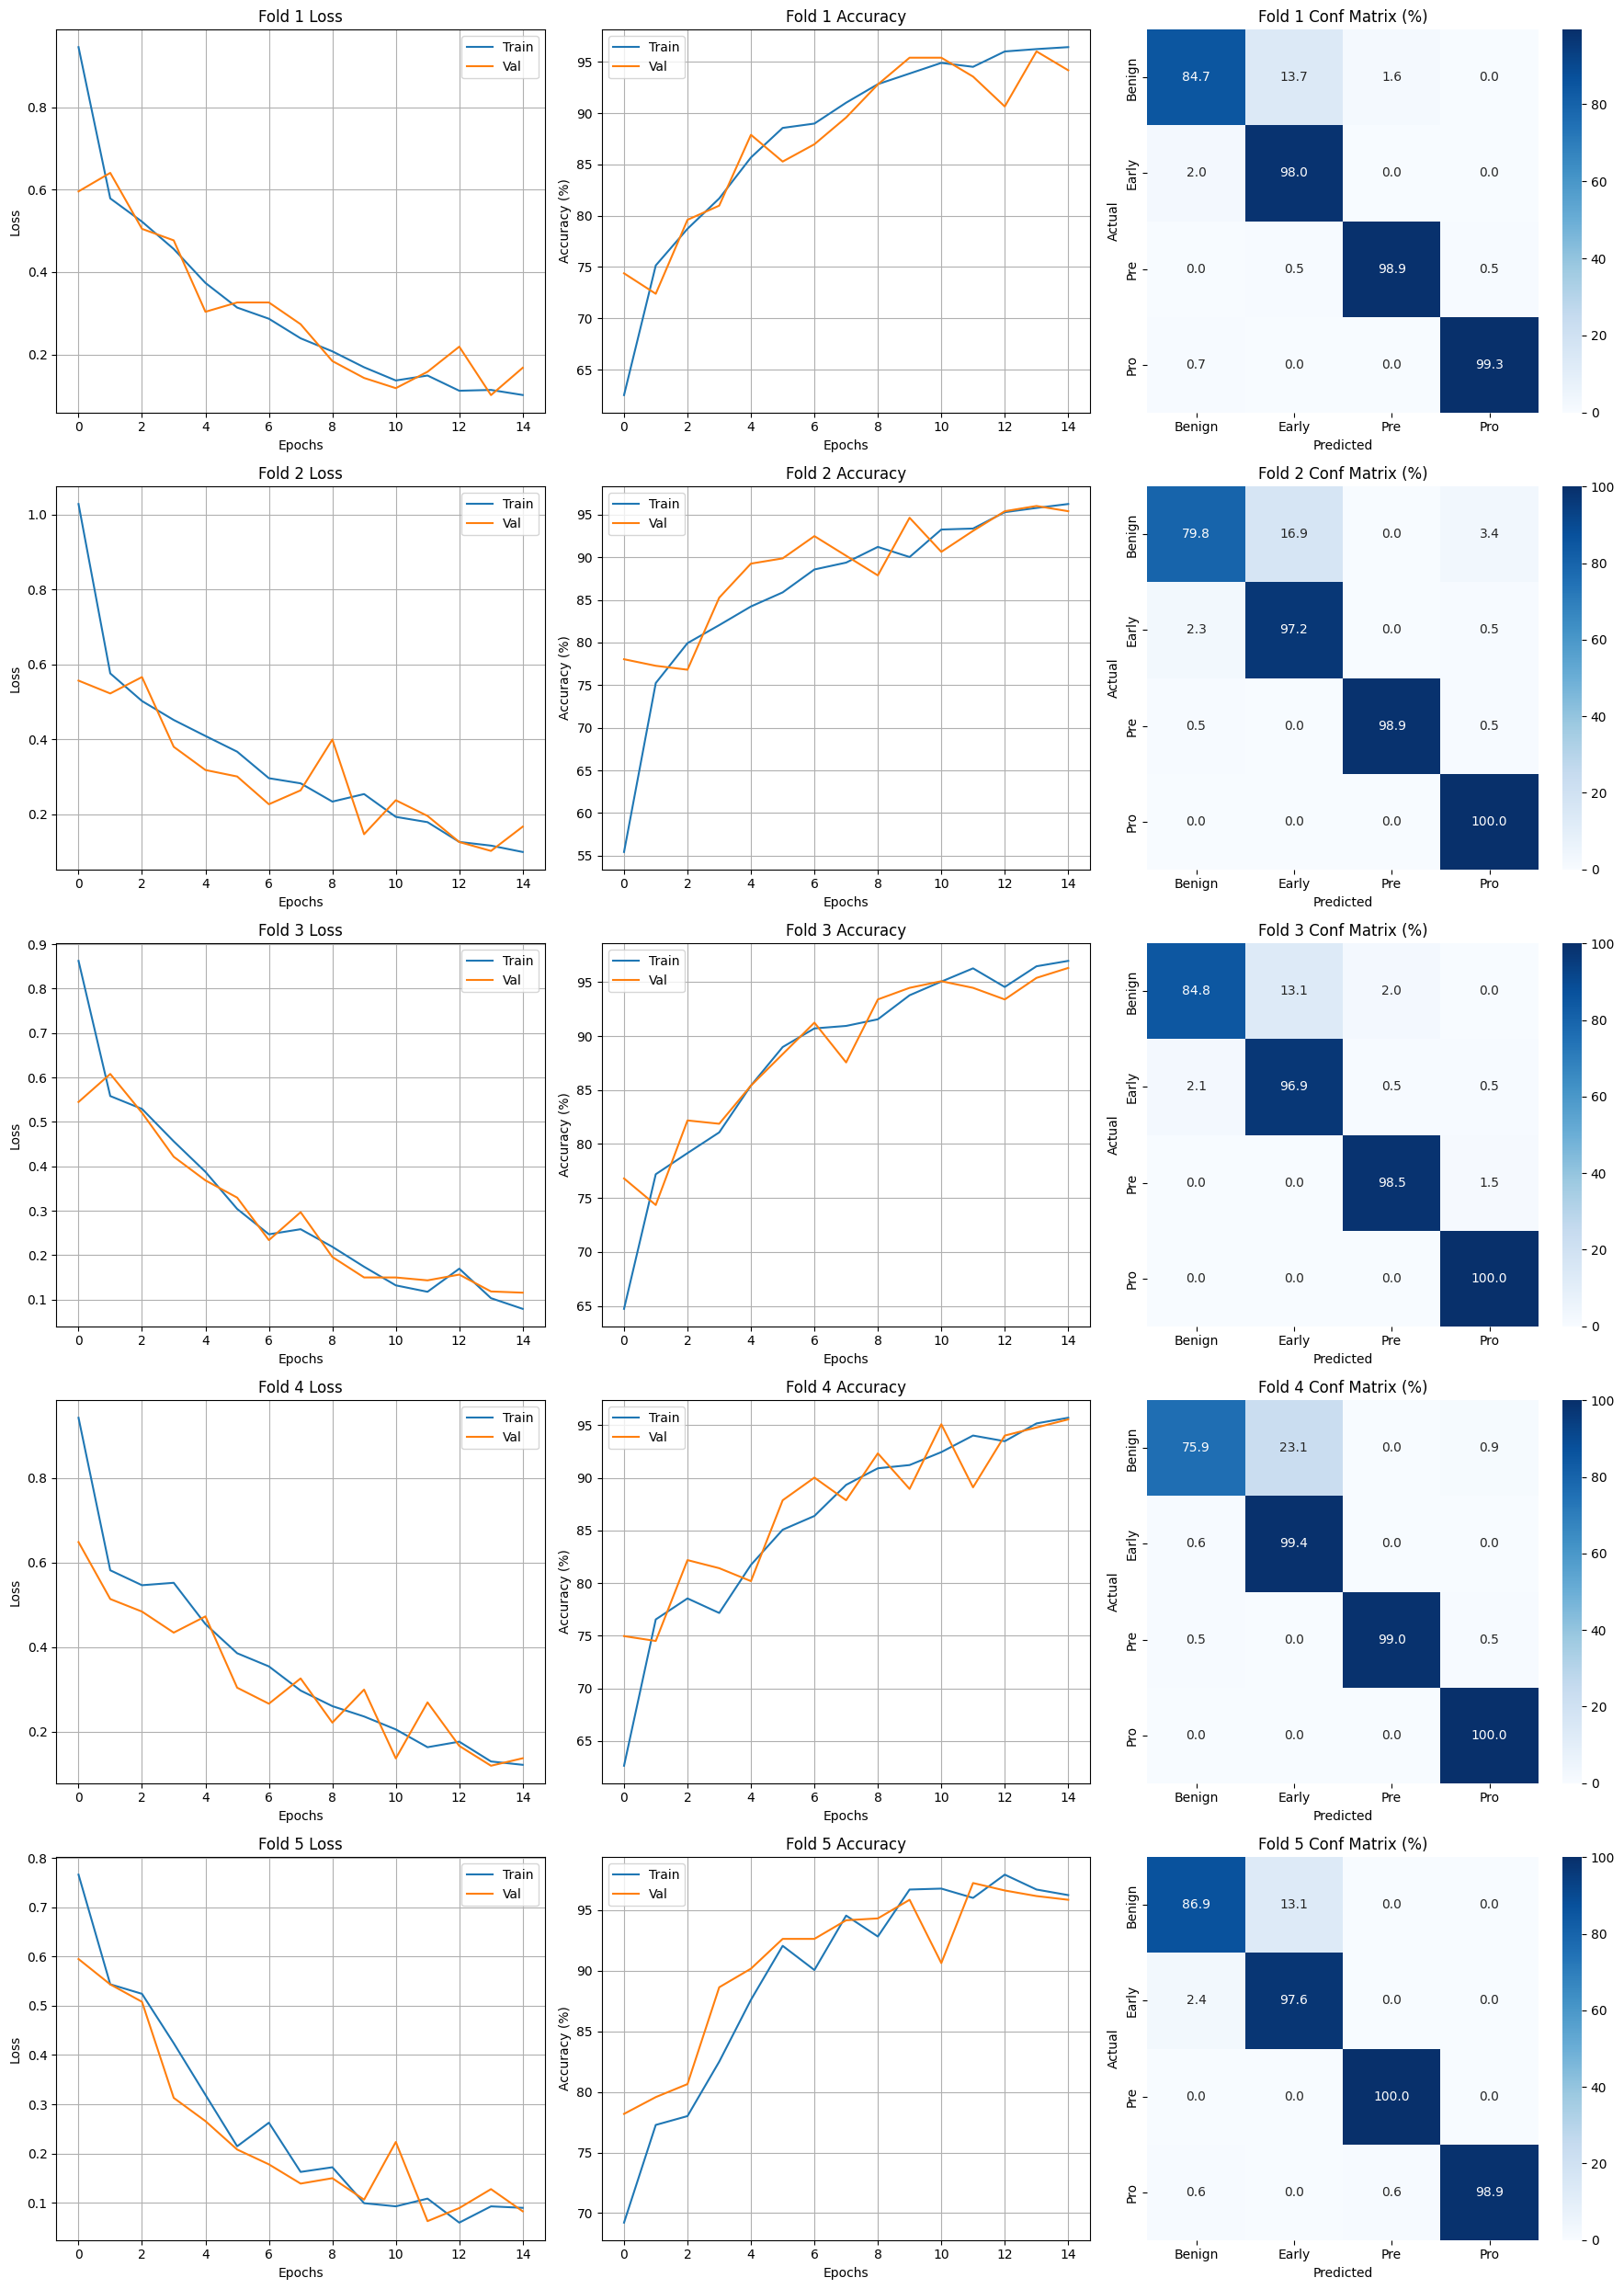

In [8]:
# --- 7. VISUALIZATION (AUTOMATIC) ---
print("\nGenerating Plots...")
fig, axes = plt.subplots(NUM_FOLDS, 3, figsize=(18, 5 * NUM_FOLDS))

for i, (hist, preds, targets) in enumerate(all_results):
    # Plot Loss (Column 1)
    ax = axes[i][0]
    ax.plot(hist['train_loss'], label='Train')
    ax.plot(hist['val_loss'], label='Val')
    ax.set_title(f'Fold {i+1} Loss')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.legend()
    ax.grid(True)

    # Plot Accuracy (Column 2)
    ax = axes[i][1]
    ax.plot(hist['train_acc'], label='Train')
    ax.plot(hist['val_acc'], label='Val')
    ax.set_title(f'Fold {i+1} Accuracy')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Accuracy (%)')
    ax.legend()
    ax.grid(True)

    # Plot Confusion Matrix (Column 3)
    ax = axes[i][2]
    cm = confusion_matrix(targets, preds)
    # Convert to Percentage
    row_sums = cm.sum(axis=1)[:, np.newaxis]
    row_sums[row_sums == 0] = 1 
    cm_pct = cm.astype('float') / row_sums * 100
    
    sns.heatmap(cm_pct, annot=True, fmt='.1f', cmap='Blues', ax=ax,
                xticklabels=CLASSES, yticklabels=CLASSES)
    ax.set_title(f'Fold {i+1} Conf Matrix (%)')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

plt.tight_layout()
plt.show()